In [ ]:
!pip install deepxde

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 179.8/179.8 kB 1.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 107.7/107.7 kB 8.2 MB/s eta 0:00:00


In [ ]:
import deepxde as dde
import tensorflow as tf
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
#import required libraries

No backend selected.
Finding available backend...


Using backend: tensorflow.compat.v1
Other supported backends: tensorflow, pytorch, jax, paddle.
paddle supports more examples now and is recommended.
Instructions for updating:
non-resource variables are not supported in the long term


Found tensorflow.compat.v1
Setting the default backend to "tensorflow.compat.v1". You can change it in the ~/.deepxde/config.json file or export the DDE_BACKEND environment variable. Valid options are: tensorflow.compat.v1, tensorflow, pytorch, jax, paddle (all lowercase)


In [ ]:
#HERE DEFINE CONSTANTS AND REQUIRED FUNCTIONS

c0, n1, n2 = 1., 1., 2. #refraction coeff
x0, y0 = 0., 0.
x1, y1 = 1., 1. #initial and final points

no_of_output = 2 #corresponds to x,y
num_domain = 1000
n_adam = 2000
learning_r = 1e-3 #adam
loss_weights = [1., 0.01, 1., 1., 1., 1.]

t0 = 0.0
t1 = 1.0
T = dde.Variable(t1) #end time as dde variable

# Set random seed
seed = 104 #6969 was aslo working fine %420 is fine
np.random.seed(seed)
tf.random.set_seed(seed)
dde.backend.tf.random.set_random_seed(seed)

#define required functions in this block
def ode(t,u):
  x = u[:, 0:1]
  y = u[:, 1:2]
  dxdt = dde.grad.jacobian(x,t) #dx dt from paper
  dydt = dde.grad.jacobian(y,t) #dy dt from paper
  refraction = n1 + 0.5*(n2 - n1)*(1. - tf.cos(2.*np.pi*y)) #how coefficient evoles over time

  ode1 = (dxdt/T)**2 + (dydt/T)**2 - (c0/refraction)**2
  ode2 = T * tf.ones_like(x) #ngl idk why that is they dont mention in paper

  return [ode1, ode2]

def sigmoid_tf(x,y): #sigmoid function but for tensorflow, idk why x is arg
  out = 1./(1+tf.exp(-y))
  return out

def boundaryLeft (t, on_boundary):
  flag = np.isclose(t[0], t0) #check whether at init time we are clos to LHS
  return on_boundary * flag

def boundaryRight (t, on_boundary): #check whether at init time we are clos to RHS
  flag = np.isclose(t[0], t1)
  return on_boundary * flag

Compiling model...
Building feed-forward neural network...
'build' took 0.123955 s



/usr/local/lib/python3.10/dist-packages/deepxde/nn/tensorflow_compat_v1/fnn.py:116: UserWarning: `tf.layers.dense` is deprecated and will be removed in a future version. Please use `tf.keras.layers.Dense` instead.
  return tf.layers.dense(


'compile' took 1.346735 s

Training model...

Step      Train loss                                                      Test loss                                                       Test metric
0         [6.22e-02, 1.00e-02, 2.50e-01, 2.50e-01, 2.38e-01, 3.06e-01]    [6.22e-02, 1.00e-02, 2.50e-01, 2.50e-01, 2.38e-01, 3.06e-01]    []  
0 [1.00e+00]
100       [5.89e-02, 1.14e-02, 5.57e-02, 5.17e-02, 5.76e-02, 6.04e-02]    [5.89e-02, 1.14e-02, 5.57e-02, 5.17e-02, 5.76e-02, 6.04e-02]    []  
100 [1.07e+00]
200       [5.89e-02, 1.35e-02, 4.62e-02, 4.59e-02, 4.71e-02, 5.09e-02]    [5.89e-02, 1.35e-02, 4.62e-02, 4.59e-02, 4.71e-02, 5.09e-02]    []  
200 [1.16e+00]
300       [5.78e-02, 1.55e-02, 3.94e-02, 4.19e-02, 3.96e-02, 4.55e-02]    [5.78e-02, 1.55e-02, 3.94e-02, 4.19e-02, 3.96e-02, 4.55e-02]    []  
300 [1.24e+00]
400       [5.69e-02, 1.73e-02, 3.42e-02, 3.92e-02, 3.41e-02, 4.19e-02]    [5.69e-02, 1.73e-02, 3.42e-02, 3.92e-02, 3.41e-02, 4.19e-02]    []  
400 [1.31e+00]
500       [5.65e

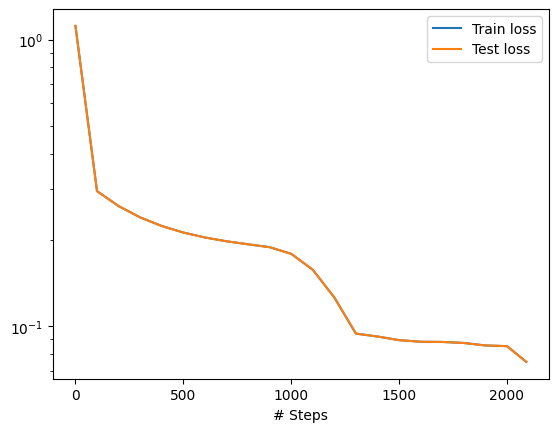

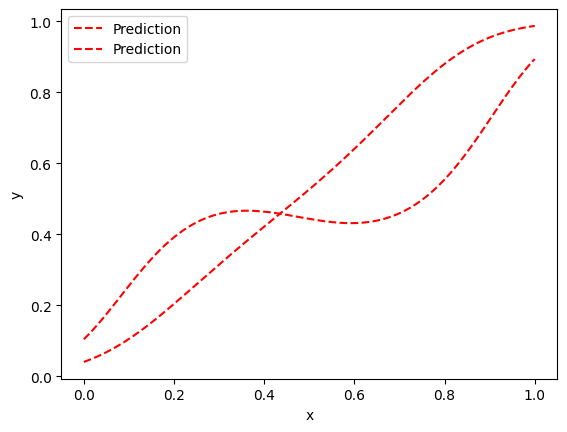

'ourVersion-2090.ckpt'

In [ ]:
timeVec = dde.geometry.TimeDomain(t0,t1) ##defnie time domain

#boundary conditions on LHS
bc0x = dde.icbc.DirichletBC(timeVec, lambda t: np.array([x0]), boundaryLeft, component=0)
bc0y = dde.icbc.DirichletBC(timeVec, lambda t: np.array([y0]), boundaryLeft, component=1)

#boundary conditions on RHS
bc1x = dde.icbc.DirichletBC(timeVec, lambda t: np.array([x1]), boundaryRight, component=0)
bc1y = dde.icbc.DirichletBC(timeVec, lambda t: np.array([y1]), boundaryRight, component=1)

#solve ODE given boundary conditions, time domain, numerical domain, this is input to the solver
data = dde.data.PDE(timeVec, ode, [bc0x, bc0y, bc1x, bc1y], num_domain=num_domain, num_boundary=2)

#create forward neural network 1 input, 3 hidden layers of 64 neurons each and 2 outputs
snellPINN = dde.nn.FNN([1]+ 3 * [64] + [no_of_output],'tanh','Glorot normal')
snellPINN.apply_output_transform(sigmoid_tf)

#every 100 steps choose data from different subset
resampler = dde.callbacks.PDEPointResampler(period=100)

#every 10 steps print where in Time domain we are (between 0 and 1)
variable = dde.callbacks.VariableValue(T, period=100)

#save state of the model every 500 steps
ckpts = dde.callbacks.ModelCheckpoint('checkpoint', period=500)

#create model that incomporates ODE and FNN architecture
modelSnellPINN = dde.Model(data, snellPINN)

#compile and train with ADAM (a moze nie dam ;))
modelSnellPINN.compile("adam", lr=learning_r, loss_weights=loss_weights, external_trainable_variables=T)
losshistory, train_state = modelSnellPINN.train(display_every=100, iterations=n_adam, callbacks=[resampler, variable, ckpts])

#improve with LFBGS
modelSnellPINN.compile("L-BFGS", loss_weights=loss_weights, external_trainable_variables=T)
losshistory, train_state = modelSnellPINN.train(display_every=100, callbacks=[resampler, variable, ckpts])

dde.saveplot(losshistory, train_state, issave=True, isplot=True) #save learnign progress

#save the model
modelSnellPINN.save('ourVersion')


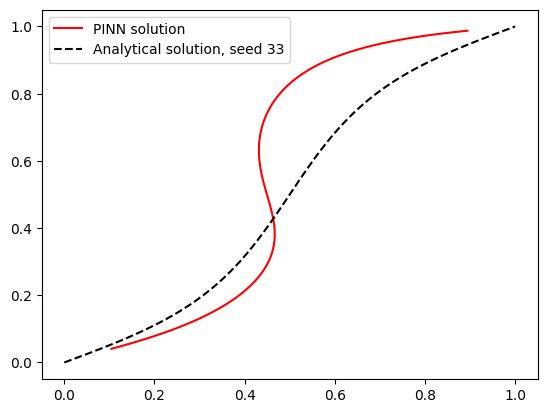

In [ ]:
t = np.linspace(t0, t1, 101) #time axis
uu = modelSnellPINN.predict(np.array([t]).T) #use model for prediction
plt.plot(uu[:, 0], uu[:, 1], 'r', label="PINN solution")

yy = np.linspace(0, 1, 101)
xx = np.arctan(2. * np.tan(np.pi * yy)) / np.pi
xx[len(xx) // 2 + 1:] += 1
plt.plot(xx, yy, 'k--',label="Analytical solution, seed 33")

plt.legend()
plt.show()